# Mastering the Process of Data Science - Final Project

## Introduction

The following project aims to provide some hands-on experience working with noise datasets and is part of the final assessment required to sucessfully complete the Mastering Process of Data Science Course at Central European University in Budapest.  
The activity consists of 3 different datasets:

Drinks.csv: number of alcohol servings per capita per year for 15 years of age or older (for beer, wine and spirit) across various countries <br>
LifeExpectancy.csv: life expectancy and other health factors across various countries <br>
CountriesOfTheWorld.xlsx: geographical and socio-econometric data across various countries <br>

## The Project Goal

Explore dataset and find relationships between life expectancy, alcohol consumption and other attributes available. <br>
Draw conclusions and write a short summary (circa 1 page) of the most important factors

In [5]:
# Load necessary libraries
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from bioinfokit.analys import stat
import statsmodels.api as sm
import matplotlib.animation as animation


## Load and Prepare the Datasets

### Drinks

In [6]:
# Load drinks data and do a small check
drinks = pd.read_csv('https://github.com/yurialmeida5/MDSP_Final_Project/blob/main/Drinks.csv?raw=True')
drinks.info()
drinks.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       193 non-null    object 
 1   beer_servings                 193 non-null    object 
 2   spirit_servings               193 non-null    object 
 3   wine_servings                 193 non-null    object 
 4   total_litres_of_pure_alcohol  0 non-null      float64
dtypes: float64(1), object(4)
memory usage: 7.7+ KB


,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
0,Afghanistan,0,0,0,NaN
1,Albania,89,132,54,NaN
2,Algeria,25,0,14,NaN
3,Andorra,245,138,312,NaN
4,Angola,217,57,45,NaN


While trying to convert the columns to numeric, I found out that some of them has non-numeric strings. 
The next step is to filter out what are the rows that contain any non-numeric strings and define the replacement / delete strategy. 
Giving a quick look under the countries without at least one of those informations we have Denmark, Bahamas and Macedonia. 
Considering that the amount of countries without information are only 3 / 193 and any other replacement strategy (mean, median, etc.) would / could imply into bad / incorrect assumptions related to the countries (cultural differences, year specifics, unclear data collection process, etc.). I have decided to simply remove those values from the original dataset

In [7]:
#drinks[~drinks['beer_servings'].str.isnumeric()]
#drinks[~drinks['spirit_servings'].str.isnumeric()]
#drinks[~drinks['wine_servings'].str.isnumeric()]
drinks = drinks[drinks['beer_servings'].str.isnumeric() & drinks['spirit_servings'].str.isnumeric() & drinks['wine_servings'].str.isnumeric()]

# Convert columns to numeric
num_columns = ['beer_servings', 'spirit_servings', 'wine_servings']
drinks[num_columns] = drinks[num_columns].apply(pd.to_numeric)

In [8]:
# Create the function to transform the column total_of_pure_alcohol and apply it

def get_total_litre_of_pure_alcohol(beer, spirit, wine):
    # Define the ounce measure
    ounce = 0.0295
    beer_pure_alcohol = beer * ounce * 12 * 0.05
    wine_pure_alcohol = wine * ounce * 5 * 0.12
    spirit_pure_alcohol = spirit * ounce * 1.5 * 0.4
    return beer_pure_alcohol + wine_pure_alcohol + spirit_pure_alcohol

drinks['total_litres_of_pure_alcohol'] = drinks.apply( lambda x : get_total_litre_of_pure_alcohol(x.beer_servings, x.spirit_servings, x.wine_servings), axis=1)

In [9]:
# Remove non-important columns
# I have decided to remove those columns because we already created the column for comparison and at the end we are going to join it with many of aspects (birthrate, deathrate, etc.)
# Gets messy on the heatmap
columns_to_drop = ['beer_servings', 'spirit_servings', 'wine_servings']
drinks.drop(columns_to_drop, axis=1, inplace=True)

### Life Expectancy

In [10]:
# Load expectancy data and do a small check
life_expectancy = pd.read_csv('https://github.com/yurialmeida5/MDSP_Final_Project/blob/main/LifeExpectancy.csv?raw=True')
life_expectancy.info()
life_expectancy.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6408 entries, 0 to 6407
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   GhoCode                        6408 non-null   object 
 1   GhoDisplay                     6408 non-null   object 
 2   PublishStateCode               6408 non-null   object 
 3   PublishStateDisplay            6408 non-null   object 
 4   YearCode                       6408 non-null   int64  
 5   YearDisplay                    6408 non-null   int64  
 6   RegionCode                     6408 non-null   object 
 7   RegionDisplay                  6408 non-null   object 
 8   WorldBankIncomeGroupGroupCode  5244 non-null   object 
 9   WorldBankIncomeGroupDisplay    5244 non-null   object 
 10  CountryCode                    6408 non-null   object 
 11  CountryDisplay                 6408 non-null   object 
 12  SexCode                        6408 non-null   o

,GhoCode,GhoDisplay,PublishStateCode,PublishStateDisplay,YearCode,YearDisplay,RegionCode,RegionDisplay,WorldBankIncomeGroupGroupCode,WorldBankIncomeGroupDisplay,CountryCode,CountryDisplay,SexCode,SexDisplay,DisplayValue,Numeric
0,WHOSIS_000001,Life expectancy at birth (years),PUBLISHED,Published,2013,2013,EMR,Eastern Mediterranean,NaN,NaN,AFG,Afghanistan,BTSX,Both sexes,61,61.25205
1,WHOSIS_000001,Life expectancy at birth (years),PUBLISHED,Published,2013,2013,EMR,Eastern Mediterranean,NaN,NaN,AFG,Afghanistan,FMLE,Female,62,61.97733
2,WHOSIS_000001,Life expectancy at birth (years),PUBLISHED,Published,2013,2013,EMR,Eastern Mediterranean,NaN,NaN,AFG,Afghanistan,MLE,Male,61,60.51228
3,WHOSIS_000001,Life expectancy at birth (years),PUBLISHED,Published,2012,2012,EMR,Eastern Mediterranean,WB_LI,Low_income,AFG,Afghanistan,BTSX,Both sexes,60,60.00000
4,WHOSIS_000001,Life expectancy at birth (years),PUBLISHED,Published,2012,2012,EMR,Eastern Mediterranean,WB_LI,Low_income,AFG,Afghanistan,FMLE,Female,61,61.00000


In [11]:
# Check each one of the possibilities should be used
life_expectancy['GhoDisplay'].unique()
# In this case life expectancy at birth is the one that makes the most sense out of 3 for what we are going to measure.
life_expectancy = life_expectancy[life_expectancy['GhoDisplay'] == 'Life expectancy at birth (years)']
# Check what are max year displayed by country 
life_expectancy.groupby('CountryDisplay').agg({'YearCode': ['max']})['YearCode']['max'].unique()
# All the countries have 2013 as the last year published, so let's filter out the other years 
life_expectancy = life_expectancy[life_expectancy['YearCode'] == 2013]

In [12]:
# Remove non-important columns
# Columns that have same value, or no value at all or repeated. Not important for our analysis.
columns_to_drop = ['GhoCode', 'GhoDisplay', 'PublishStateCode', 'PublishStateDisplay', 'YearCode', 'YearDisplay', 'RegionDisplay', 'WorldBankIncomeGroupGroupCode', 'WorldBankIncomeGroupDisplay', 'CountryCode', 'SexCode', 'DisplayValue']
life_expectancy.drop(columns_to_drop, axis=1, inplace=True)
# I have decided to keep using the numeric column instead of the DisplayValue, because although years make more sense to be displayed rounded, 
# I can capture better (more precisely) the correlation between the alcohol and and lifetime having more decimal places
# Rename the columns names on life expectancy
life_expectancy.rename(columns={'CountryDisplay':'country', 'Numeric' : 'life_expectancy_years', 'SexDisplay' : 'sex'}, inplace=True)

In [13]:
# Before joining the datasets, let's check possible differences in the countries names spelling
print('Exists in Drinks but not in Life Expectancy:')
print(list(set(drinks.country) - set(life_expectancy.country.unique())))
print('Exists in Life Expectancy but not in Drinks:')
print(list(set(life_expectancy.country.unique()) - set(drinks.country)))

# Rename the countries on the life expectancy dataset so we can merge both using their names. 
# There are a few functions on the internet that can be used to match those 2 lists, however the best and most precise way to do it is individually - 5/10min
life_expectancy['country'] = life_expectancy['country'].replace({'United States of America':'USA', 'Bosnia and Herzegovina':'Bosnia-Herzegovina', 'United Kingdom of Great Britain and Northern Ireland' : 'United Kingdom', 
'Bolivia (Plurinational State of)': 'Bolivia', 'Syrian Arab Republic':'Syria', 'Timor_Leste' : 'Timor-Leste', 'Venezuela (Bolivarian Republic of)':'Venezuela', 'United Republic of Tanzania':'Tanzania',
'Micronesia (Federated States of)' : 'Micronesia' , 'Sao Tome and Principe' : 'Sao Tome & Principe', 'Iran (Islamic Republic of)' : 'Iran' , 'Trinidad and Tobago' : 'Trinidad & Tobago',
'Democratic Republic of the Congo' : 'DR Congo', 'Republic of Moldova' : 'Moldova', 'Saint Vincent and the Grenadines' : 'St. Vincent & the Grenadines', 'Saint Kitts and Nevis' : 'St. Kitts & Nevis',
'Brunei Darussalam' : 'Brunei', 'Antigua and Barbuda' : 'Antigua & Barbuda' , 'Guinea_Bissau' : 'Guinea-Bissau', 'Republic of Korea' : 'South Korea', "Democratic People's Republic of Korea" : 'North Korea',
"Lao People's Democratic Republic":'Laos', "Côte d'Ivoire" : "Cote d'Ivoire", 'Saint Lucia' : 'St. Lucia', 'Viet Nam' : 'Vietnam'})

Exists in Drinks but not in Life Expectancy:
['DR Congo', 'Bolivia', 'United Kingdom', 'Laos', "Cote d'Ivoire", 'St. Lucia', 'North Korea', 'Moldova', 'Timor-Leste', 'Venezuela', 'Vietnam', 'South Korea', 'Micronesia', 'Iran', 'USA', 'Bosnia-Herzegovina', 'St. Vincent & the Grenadines', 'Tanzania', 'Sao Tome & Principe', 'Trinidad & Tobago', 'Brunei', 'Syria', 'Antigua & Barbuda', 'St. Kitts & Nevis', 'Guinea-Bissau']
Exists in Life Expectancy but not in Drinks:
['United States of America', 'Sao Tome and Principe', 'Viet Nam', 'United Kingdom of Great Britain and Northern Ireland', 'The former Yugoslav republic of Macedonia', 'Saint Vincent and the Grenadines', 'Brunei Darussalam', 'Bosnia and Herzegovina', 'South Sudan', 'Timor_Leste', 'United Republic of Tanzania', 'Republic of Moldova', 'Republic of Korea', "Democratic People's Republic of Korea", "Lao People's Democratic Republic", 'Trinidad and Tobago', 'Guinea_Bissau', 'Micronesia (Federated States of)', "Côte d'Ivoire", 'Denmark

In [14]:
drinks_and_lifetime = drinks.merge(life_expectancy, how='inner', on = 'country')
drinks_and_lifetime.head()

,country,total_litres_of_pure_alcohol,RegionCode,sex,life_expectancy_years
0,Afghanistan,0.0000,EMR,Both sexes,61.25205
1,Afghanistan,0.0000,EMR,Female,61.97733
2,Afghanistan,0.0000,EMR,Male,60.51228
3,Albania,4.8675,EUR,Both sexes,74.13000
4,Albania,4.8675,EUR,Female,75.50800


# Correlation between expected lifetime and total liters of pure alcohol

In [15]:
DEFAULT_FIGSIZE = (12,5)
plt.rcParams['figure.figsize'] = DEFAULT_FIGSIZE

<AxesSubplot:xlabel='total_litres_of_pure_alcohol', ylabel='life_expectancy_years'>

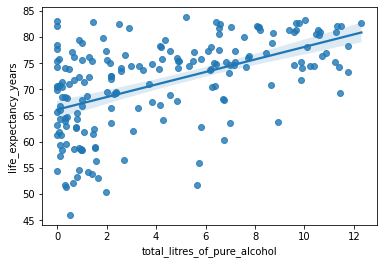

In [16]:
sns.regplot(data=drinks_and_lifetime[drinks_and_lifetime.sex == 'Both sexes'], x='total_litres_of_pure_alcohol', y='life_expectancy_years')

In [17]:
def get_correlations_dataframe(data, group1, var1, var2):
    corr_dataframe = {}
    for each_group in data[group1].unique():
        corr_dataframe[each_group] = stats.spearmanr(data[data[group1] == each_group][var1], data[data[group1] == each_group][var2])
    corr_dataframe = pd.DataFrame.from_dict(corr_dataframe).T
    corr_dataframe.columns = ['pearson_coefficient', 'p-value']
    return corr_dataframe

life_and_drink_corr = get_correlations_dataframe(drinks_and_lifetime, 'sex', 'total_litres_of_pure_alcohol', 'life_expectancy_years')
life_and_drink_corr

,pearson_coefficient,p-value
Both sexes,0.510991,4.966503e-14
Female,0.575376,3.857819e-18
Male,0.445479,1.191467e-10


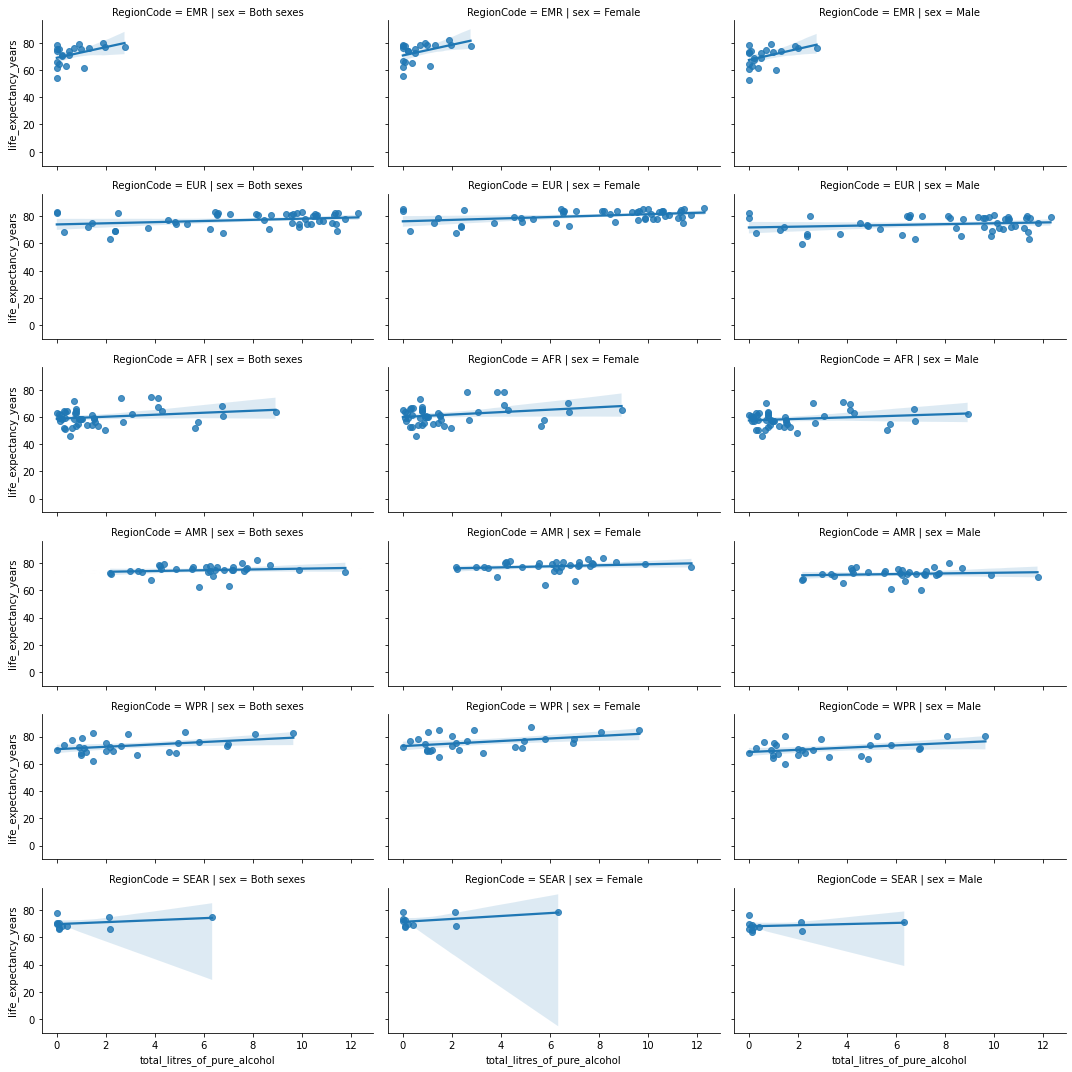

In [18]:
g = sns.FacetGrid(drinks_and_lifetime, col="sex", row='RegionCode', height=2.5, aspect=2)
g.map(sns.regplot, "total_litres_of_pure_alcohol" ,"life_expectancy_years")

Taking a quick look at the graphs and the correlation table, it's possible to mention that although there is a significant impact (p-value) between the total liters of alcohol and life expectancy, the correlation didn't prove itself quite strong. This is possible due to the amount of countries with 0 alchohol consumption but still quite resonable life expectancy. Also, theory suggest that life expectancy is also impacted by other factors like GDP per capita, health access, etc.

### CountriesOfTheWorld

In [19]:
countries_world = pd.read_excel('https://github.com/yurialmeida5/MDSP_Final_Project/blob/main/CountriesOfTheWorld.xls?raw=True', sheet_name='Sheet1')
countries_world.info()
countries_world.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 16 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Data is public domain from US government.  229 non-null    object
 1   Unnamed: 1                                 228 non-null    object
 2   Unnamed: 2                                 228 non-null    object
 3   Unnamed: 3                                 229 non-null    object
 4   Unnamed: 4                                 229 non-null    object
 5   Unnamed: 5                                 229 non-null    object
 6   Unnamed: 6                                 225 non-null    object
 7   Unnamed: 7                                 226 non-null    object
 8   Unnamed: 8                                 228 non-null    object
 9   Unnamed: 9                                 211 non-null    object
 10  Unnamed: 10                           

,Data is public domain from US government.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,Compiled by combining information from files a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Country,Region,Population,Area,Pop. Density,Coastline,Net migration,Infant mortality,GDP,Literacy,Phones,Arable,Crops,Other,Birthrate,Deathrate
3,NaN,NaN,NaN,sq. mi.,per sq. mi.,coast/area ratio,NaN,per 1000 births,$ per capita,%,per 1000,%,%,%,NaN,NaN
4,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,47.96,0,23.06,163.07,700,36,3.22,12.13,0.22,87.65,46.6,20.34


In [20]:
## DataPreparation
col_names = [each_element.lower() for each_element in countries_world.iloc[2].to_list()]
countries_world.columns = col_names
## Rename some specific column names - (Remove dots, percentages, and extra symbols) - this can be bad for coding while referring columns names and etc.
countries_world.rename(columns={'area': 'area_sqm', "pop. density": 'pop_density_per_sqm', "net migration" : 'net_migration', "infant mortality":'infant_mortality_per_1000_births',
'gdp':'gdp_per_capita', 'literacy':'literacy_percentage', 'phones': 'phones_per_1000_hab', 'arable' : 'arable_percentage', 'crops' : 'crops_percentage', 'other' : 'other_percentage'}, inplace=True)
# Remove first rows
countries_world.drop(range(4), inplace=True)
# Remove extra spaces from countries names
countries_world['country'] = countries_world['country'].str.strip()
# Remove region column - let's use the code we have in drinks when we merge
countries_world.drop(['region'], axis=1, inplace=True)

# Convert columns to numeric
num_columns = countries_world.columns.to_list()
num_columns.remove('country')
countries_world[num_columns] = countries_world[num_columns].apply(pd.to_numeric)

In [21]:
# Before joining the datasets, let's check possible differences in the countries names spelling
print('Exists in Drinks_and_LifeTime but not in Countries World:')
print(list(set(drinks_and_lifetime.country) - set(countries_world.country)))
print('Exists in Countries Worls but not in Drinks_and_LifeTime:')
print(list(set(countries_world.country) - set(drinks_and_lifetime.country)))

countries_world['country'] = countries_world['country'].replace({'Bosnia & Herzegovina':'Bosnia-Herzegovina', 'East Timor': 'Timor-Leste' , 'Saint Lucia' : 'St. Lucia',
'Congo, Dem. Rep.': 'DR Congo','Saint Vincent and the Grenadines' : 'St. Vincent & the Grenadines', 'United States' : 'USA' , 'Korea, North' : 'North Korea', 'Micronesia, Fed. St.' : 'Micronesia',
'Central African Rep.' : 'Central African Republic' , 'Russia' : 'Russian Federation', 'Korea, South' : 'South Korea' , 'Congo, Repub. of the' : 'Congo', 'Gambia, The': 'Gambia', 'Cape Verde' : 'Cabo Verde',
'Saint Kitts & Nevis' : 'St. Kitts & Nevis' })

Exists in Drinks_and_LifeTime but not in Countries World:
['DR Congo', 'Central African Republic', 'St. Lucia', 'Niue', 'North Korea', 'USA', 'Congo', 'St. Vincent & the Grenadines', 'Myanmar', 'Bosnia-Herzegovina', 'St. Kitts & Nevis', 'Cabo Verde', 'Montenegro', 'Timor-Leste', 'Gambia', 'South Korea', 'Russian Federation', 'Micronesia']
Exists in Countries Worls but not in Drinks_and_LifeTime:
['Bahamas, The', 'American Samoa', 'United States', 'Faroe Islands', 'Anguilla', 'Jersey', 'Central African Rep.', 'Burma', 'Reunion', 'Saint Kitts & Nevis', 'Bermuda', 'Guam', 'Saint Vincent and the Grenadines', 'Macedonia', 'Russia', 'Puerto Rico', 'Guadeloupe', 'Hong Kong', 'Bosnia & Herzegovina', 'Congo, Repub. of the', 'Congo, Dem. Rep.', 'Saint Helena', 'Montserrat', 'Greenland', 'Gibraltar', 'Gaza Strip', 'Turks & Caicos Is', 'Martinique', 'Western Sahara', 'Korea, South', 'Cayman Islands', 'N. Mariana Islands', 'Virgin Islands', 'Korea, North', 'Aruba', 'Liechtenstein', 'East Timor', 'S

## Find factors that are highly correlated to the expected lifetime

In [22]:
final_dataset = drinks_and_lifetime.merge(countries_world, how='inner', on='country')
final_dataset.head()

,country,total_litres_of_pure_alcohol,RegionCode,sex,life_expectancy_years,population,area_sqm,pop_density_per_sqm,coastline,net_migration,infant_mortality_per_1000_births,gdp_per_capita,literacy_percentage,phones_per_1000_hab,arable_percentage,crops_percentage,other_percentage,birthrate,deathrate
0,Afghanistan,0.0000,EMR,Both sexes,61.25205,31056997,647500,47.96,0.00,23.06,163.07,700.0,36.0,3.22,12.13,0.22,87.65,46.60,20.34
1,Afghanistan,0.0000,EMR,Female,61.97733,31056997,647500,47.96,0.00,23.06,163.07,700.0,36.0,3.22,12.13,0.22,87.65,46.60,20.34
2,Afghanistan,0.0000,EMR,Male,60.51228,31056997,647500,47.96,0.00,23.06,163.07,700.0,36.0,3.22,12.13,0.22,87.65,46.60,20.34
3,Albania,4.8675,EUR,Both sexes,74.13000,3581655,28748,124.59,1.26,-4.93,21.52,4500.0,86.5,71.20,21.09,4.42,74.49,15.11,5.22
4,Albania,4.8675,EUR,Female,75.50800,3581655,28748,124.59,1.26,-4.93,21.52,4500.0,86.5,71.20,21.09,4.42,74.49,15.11,5.22


### Categorical Values

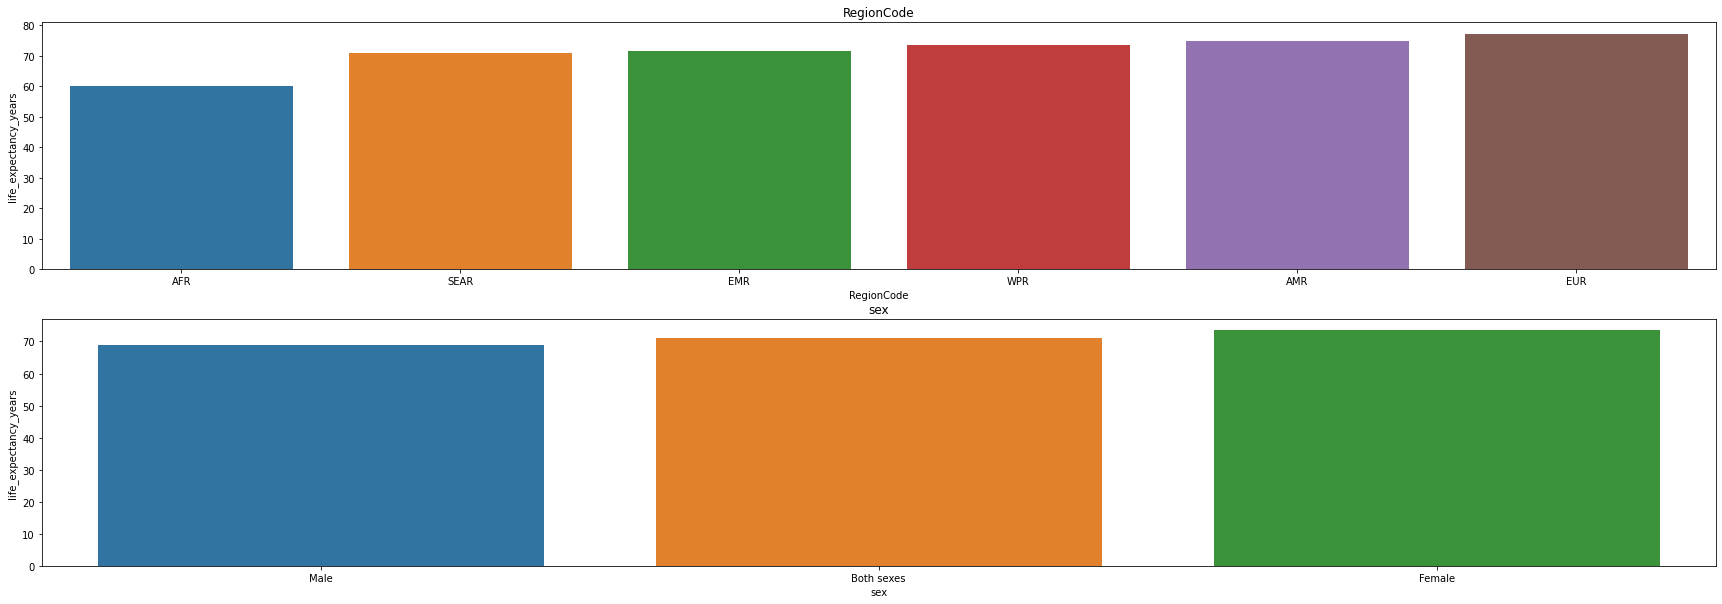

In [23]:
categorical_values = ['RegionCode', 'sex']

# Plot categorical distribuitions
fig, axes = plt.subplots(2, 1, figsize=(30,10))

for i, ax in enumerate (axes.flat):
    graph_data = final_dataset.groupby(categorical_values[i]).mean() 
    sns.barplot(ax = ax, data = graph_data, x= graph_data.index , y='life_expectancy_years', order = graph_data.sort_values('life_expectancy_years').index) 
    ax.set_title(categorical_values[i])


In [24]:
# One-Way Anova - Sex 
grouper = final_dataset.groupby('sex')
one_way_anova = pd.concat([pd.Series(v['life_expectancy_years'].tolist(), name=k) for k, v in grouper], axis=1)
print(stats.f_oneway(one_way_anova['Both sexes'], one_way_anova['Female'], one_way_anova['Male']))
res = stat()
res.tukey_hsd(df=final_dataset[['sex', 'life_expectancy_years']], res_var='life_expectancy_years', xfac_var='sex', anova_model='life_expectancy_years ~ C(sex)')
res.tukey_summary

F_onewayResult(statistic=13.635452286367492, pvalue=1.6533192741119915e-06)


C:\Users\Samsung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\bioinfokit\analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Both sexes,Female,2.360618,0.255101,4.466134,3.726151,0.023486
1,Both sexes,Male,2.318070,0.212553,4.423586,3.658990,0.026790
2,Female,Male,4.678687,2.573171,6.784204,7.385141,0.001000


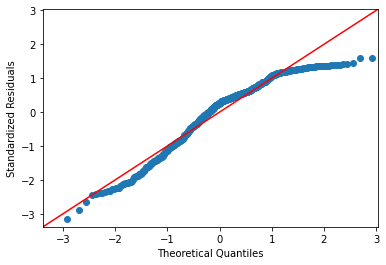

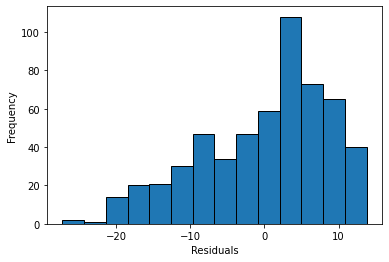

In [25]:
# Check normal distribuition assumption of my ANOVA test
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

As expected, checking exclusively the categorical values we can spot some differences in the groups mentioned bellow. I have performed an one-way-ANOVA test to demonstrate how you can check the difference between groups i.e sex (although I may have violated the indepency assumption of the variables - both sexes and female), this should be fine to demonstrate how it's done and to clear shows that those groups are indeed different from each other (p-value's). You can do the same with the region category but due to the unbalanced characteristic of it, please do some sampling before, so you have the same amount of data for each region. 

### Numeric Values

In [26]:
# Get final list of columns
categorical_values.append('country')
num_columns = list(set(final_dataset.columns) - set(categorical_values))
# For the correlation analysis, we need to separate numeric variables
numerical_analysis = final_dataset[final_dataset.sex == 'Both sexes'][num_columns]


In [27]:
# calculate the correlation matrix
corr = numerical_analysis.corr()

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

C:\Users\Samsung\AppData\Local\Temp\ipykernel_26364\383995894.py:18: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap, axis=1)\


,life_expectancy_years,phones_per_1000_hab,area_sqm,infant_mortality_per_1000_births,population,other_percentage,coastline,net_migration,deathrate,literacy_percentage,arable_percentage,gdp_per_capita,pop_density_per_sqm,crops_percentage,total_litres_of_pure_alcohol,birthrate
life_expectancy_years,1.00,0.73,0.03,-0.86,0.02,-0.10,0.05,0.12,-0.65,0.69,0.12,0.68,0.16,0.00,0.52,-0.82
phones_per_1000_hab,0.73,1.00,0.14,-0.67,0.02,-0.05,0.06,0.22,-0.24,0.59,0.13,0.85,0.34,-0.11,0.59,-0.73
area_sqm,0.03,0.14,1.00,-0.05,0.46,0.16,-0.07,0.10,0.01,0.07,-0.10,0.12,-0.06,-0.16,0.16,-0.11
infant_mortality_per_1000_births,-0.86,-0.67,-0.05,1.00,-0.01,0.18,-0.09,0.02,0.65,-0.75,-0.16,-0.59,-0.12,-0.09,-0.55,0.85
population,0.02,0.02,0.46,-0.01,1.00,-0.12,-0.05,0.02,-0.06,-0.02,0.19,-0.01,-0.02,-0.07,-0.01,-0.07
other_percentage,-0.10,-0.05,0.16,0.18,-0.12,1.00,-0.14,0.24,0.09,-0.14,-0.85,0.06,0.05,-0.59,-0.18,0.17
coastline,0.05,0.06,-0.07,-0.09,-0.05,-0.14,1.00,-0.28,-0.12,0.08,-0.10,-0.03,0.21,0.42,-0.06,-0.02
net_migration,0.12,0.22,0.10,0.02,0.02,0.24,-0.28,1.00,0.10,-0.06,-0.05,0.41,0.20,-0.38,-0.02,-0.04
deathrate,-0.65,-0.24,0.01,0.65,-0.06,0.09,-0.12,0.10,1.00,-0.36,0.03,-0.19,-0.02,-0.22,-0.05,0.40
literacy_percentage,0.69,0.59,0.07,-0.75,-0.02,-0.14,0.08,-0.06,-0.36,1.00,0.12,0.50,0.09,0.09,0.60,-0.78


According to the matrix above, the most correlated factor related to life expectancy in years was infant_mortality. What makes total sense, specially considering the fact that this attribute (low infant mortallity) is inevitably related to what we can forecast in a country with long life expectancy. Less kids surviving longer, more observations to pull down the life expectancy of a country as a whole. <br>
The fact that the data analysis corroborates with the actual theoretical knowledge is a fantastic sign that the results have great potential to lead to important insights and future analysis. <br> 
One good example of possible future investigation that can be done is to check how those numbers change when we have different regions on it. For upcoming possible studies and reference, please get examples from the graphs bellow: 


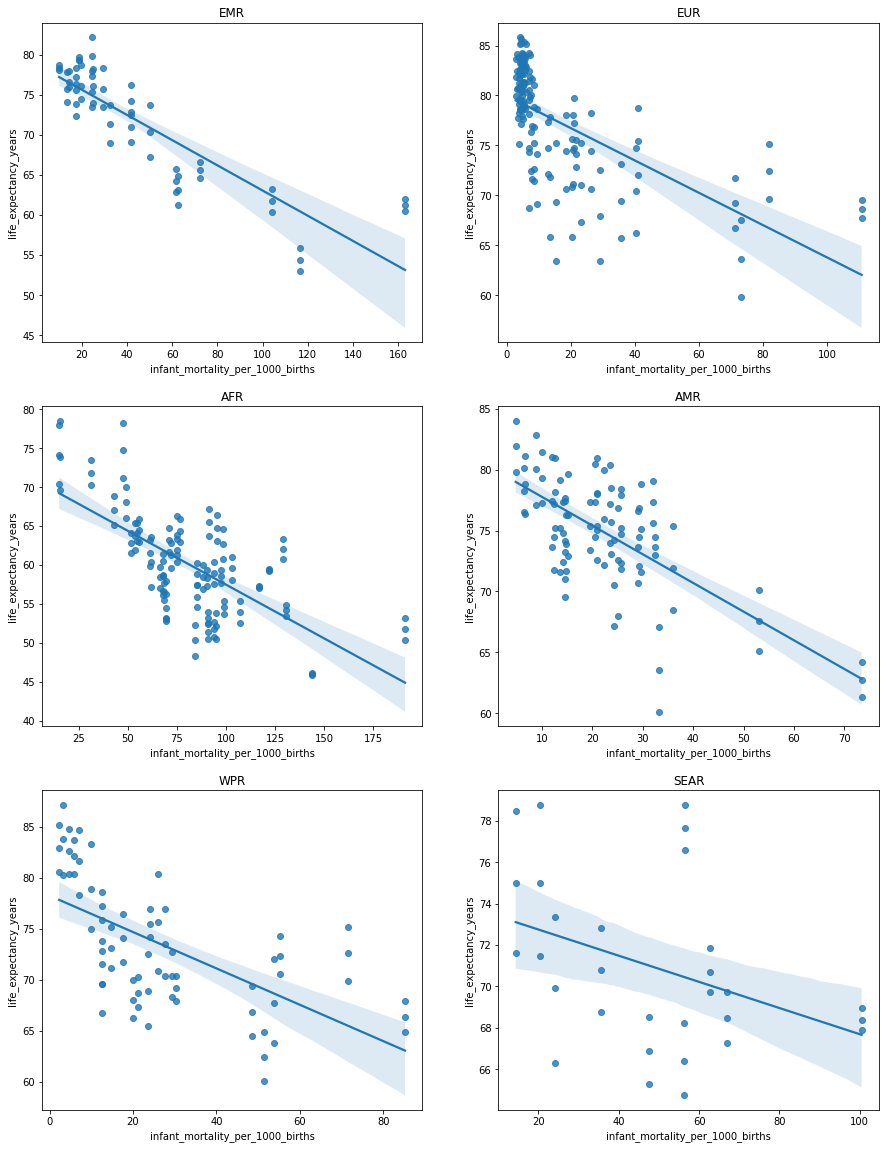

In [28]:
fig, axes = plt.subplots(3, 2, figsize=(15,20))

region_cat = final_dataset.RegionCode.unique()

for i, ax in enumerate (axes.flat):
    data = final_dataset[final_dataset.RegionCode == region_cat[i]]
    sns.regplot(ax = ax , y='life_expectancy_years', x='infant_mortality_per_1000_births', data= data)
    ax.set_title(region_cat[i])